Before starting to work on the data, we need to obtain the data from the data sources. In order to do so I used web scraping technique and pandas read_csv function to collect the data.

# Web Scraping - daily_treasury_yield_curve_rate

In [ ]:
import requests
from lxml import html
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup as bs
from datetime import datetime

In [ ]:
URL = 'https://data.treasury.gov/feed.svc/DailyTreasuryYieldCurveRateData'
COLUMNS = ['Date','1 Mo','2 Mo','3 Mo','6 Mo','1 Yr','2 Yr','3 Yr','5 Yr','7 Yr','10 Yr','20 Yr','30 Yr']

In [ ]:
def process_data(soup):
    data = soup.find_all('m:properties')[0]
    data = data.text
    data = data.split('\n')
    data = data[2:-2]
    return data

def create_new_row(data,columns):
    new_row = dict()
    
    for idx,(key,value) in enumerate(zip(columns,data)):
        if idx == 0:
            value = datetime.strptime(value, '%Y-%m-%dT%H:%M:%S')
        else:
            value = round(float(value),2) if value != '' else 0
                
        new_row[key] = value
        
    return new_row

def get_data_from_link(link,columns):
    sauce = urllib.request.urlopen(link).read()
    soup = bs(sauce,'xml')
    data = process_data(soup)
    new_row = create_new_row(data,columns)
    return new_row

sauce = urllib.request.urlopen(URL).read()
soup = bs(sauce,'xml')
df = pd.DataFrame(columns=COLUMNS)
for idx,link in enumerate(soup.find_all('id')):
    if idx>0:
        daily_yield_curve_rate_data = get_data_from_link(link.text,COLUMNS)
        df = df.append(daily_yield_curve_rate_data,ignore_index=True)

df.to_csv('daily_treasury_yield_curve_rate.csv')


# Web Scraping - BAA10Y

In [ ]:
import pandas as pd
import io
import requests

URL = r'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=BAA10Y&scale=left&cosd=1986-01-02&coed=2019-12-03&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2019-12-05&revision_date=2019-12-05&nd=1990-02-02'
c = pd.read_csv(URL)
print(c)

# Read data

In [1]:
import pandas as pd
import numpy as np

daily_treasury_yield_curve_rate_df = pd.read_csv('daily_treasury_yield_curve_rate.csv',
                                                 parse_dates=['Date'], index_col='Date')
baa10y_df = pd.read_csv('BAA10Y.csv', parse_dates=['DATE'], index_col='DATE')

In [2]:
PERIODS = ['3 Mo','1 Yr','5 Yr','10 Yr','30 Yr']
FONT_SIZE = 10
FIGSIZE = (10,5)
START_DATE='1990-01-01'
END_DATE = '2006-01-01'

In [20]:
def prepare_data(df, interest_periods, data_source,
                 start_date='1990-01-01', end_date = '2020-01-01',
                 fill=False, add_freq=False, freq='3m'):
    
    if data_source == 'yield':
        data = df[interest_periods]
    elif data_source == 'baa10y':
        data = df[interest_periods]
        data = data.replace('.',np.nan)
        data = data.dropna()
        data = data.astype(float)
        
    data = data.loc[start_date:end_date]
    data = data.sort_index(axis=0)

    if add_freq:
        data = data.asfreq(freq=freq)

    if fill:
        data = data.fillna(method='ffill')

    return data

# 1.a Finding trend and seasonality

We can decompose time series to 3 main components: trend, seasonality, and noise (random vairable).
There are 2 main models that uses these components:

1. Additive model: y = trend + seasonality + noise
2. Multiplicative model: y = trend x seasonality x noise

In multiplicative model the variance of the seasonality is increasing (or decreasing) over time, while in additive model the varaince of the seasonality doesn't change much.
I used seasonal_decompose function (from statsmodels package) to decompose the time series into trend and seasonality. This function requires:

1. Model type. 
2. Frequency (which can be thought of as the seasonality)
3. No missing data. 

Due to this, I checked the rolling standart deviation of each time series to decide the model type. Furthermore, for seasonality  period of time of 1 quarter (3 months) is used. (The seasonality changes for different periods of time).

In this section, we were asked to work on data between 1990 to 2005.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

In [22]:
def plot_data(data, xlabel='', ylabel='', title=''):
    plt.figure(figsize=FIGSIZE)
    ax = plt.axes()
    ax.tick_params(axis='both', labelsize=FONT_SIZE)
    plt.xlabel(xlabel, fontdict={'size':FONT_SIZE})
    plt.ylabel(ylabel)
    plt.title(title)
    data.plot()

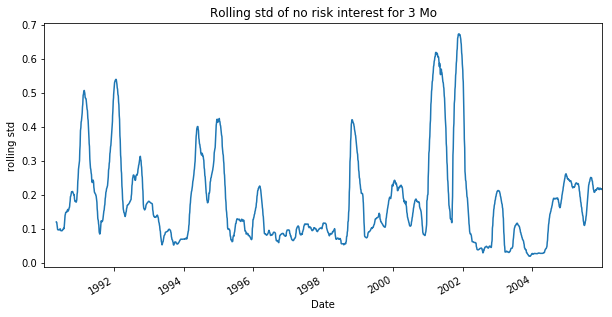

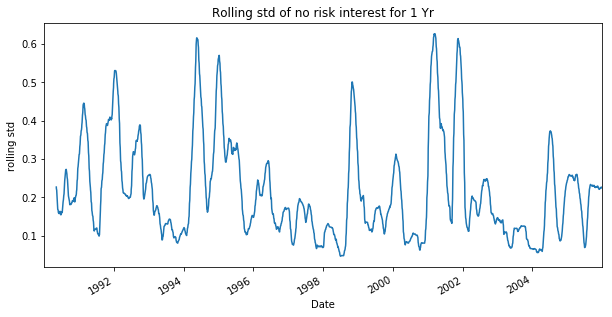

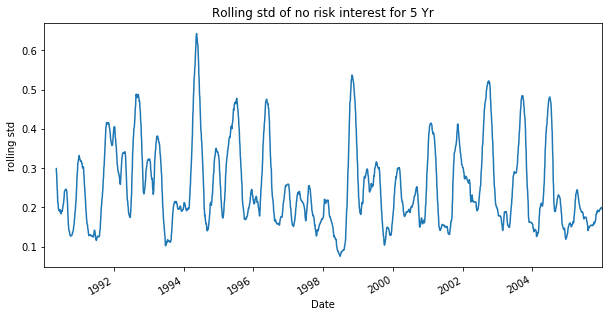

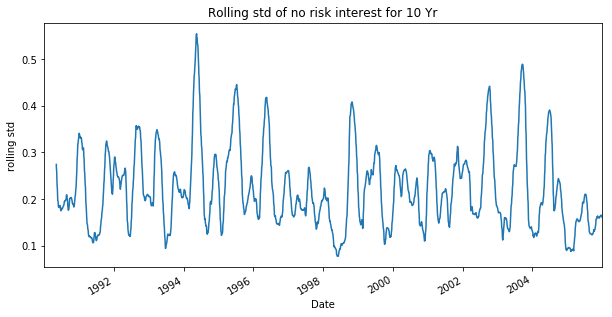

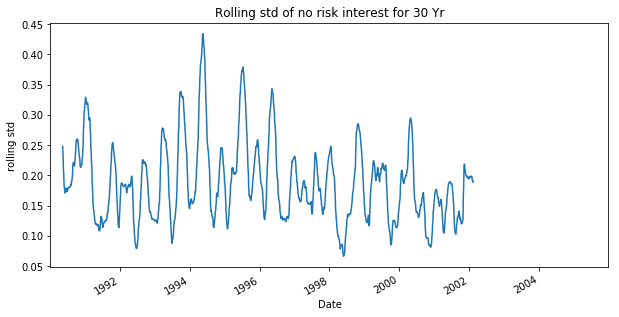

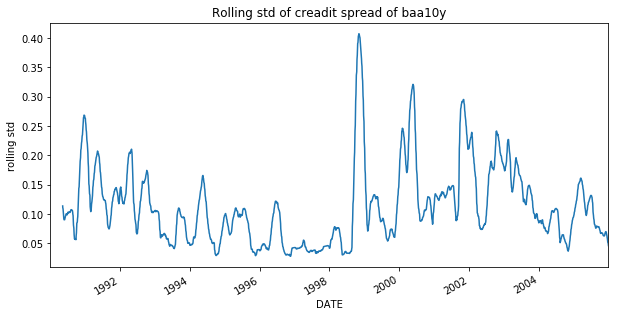

In [23]:
def plot_rolling_std(data,period):
    rolling_std = data.rolling(window=90).std()
    if period != 'baa10y':
        plot_data(data = rolling_std, xlabel = period, ylabel = 'rolling std',
                 title='Rolling std of no risk interest for {period}'.format(period=period))
    else:
        plot_data(data = rolling_std, xlabel = period, ylabel = 'rolling std',
                 title='Rolling std of creadit spread of baa10y')
        
for period in PERIODS:  
    data = prepare_data(daily_treasury_yield_curve_rate_df, interest_periods=period, data_source='yield',
                        end_date=END_DATE)
    plot_rolling_std(data,period)

data = prepare_data(baa10y_df, interest_periods='BAA10Y', data_source='baa10y',
                    start_date=START_DATE, end_date=END_DATE)
plot_rolling_std(data,'baa10y')

Since the standart deviation is not increasing or decresing over time, but volatile, *I chose to use the addtive model*.

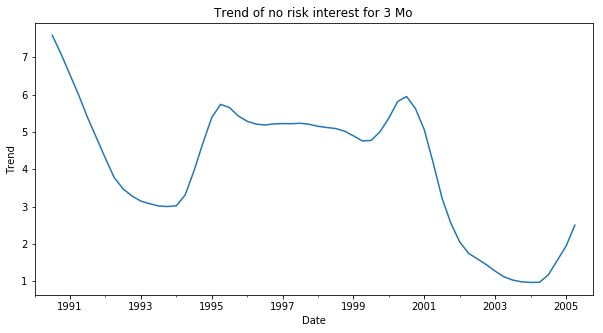

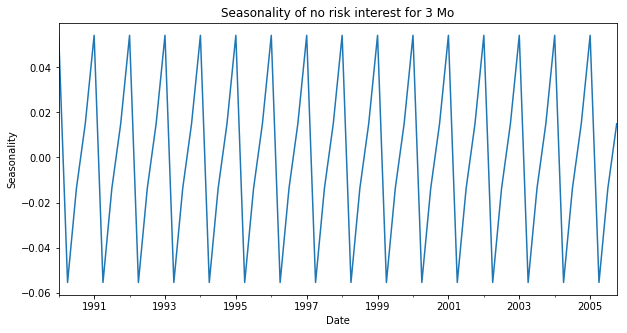

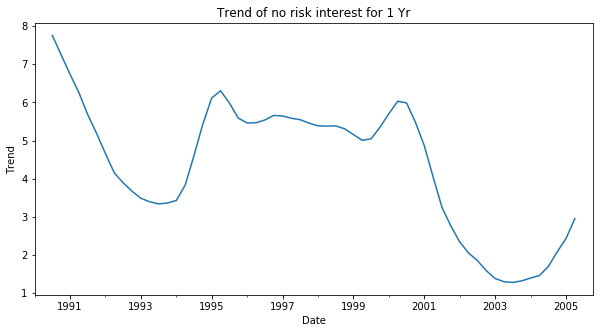

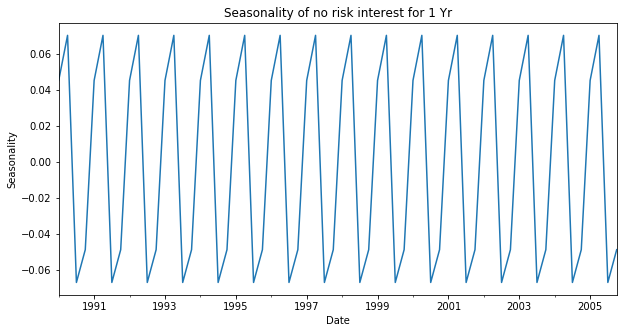

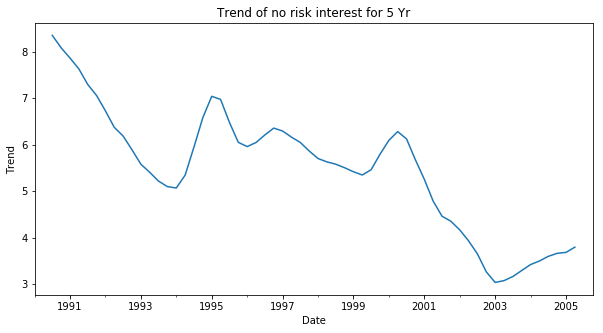

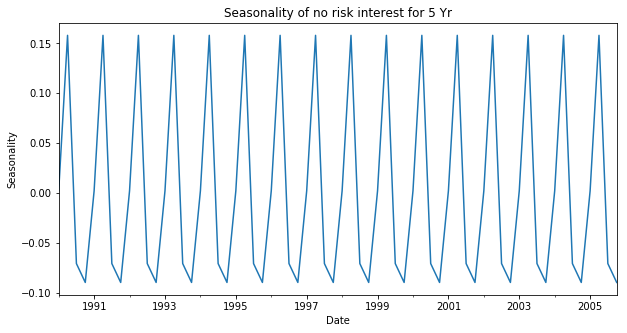

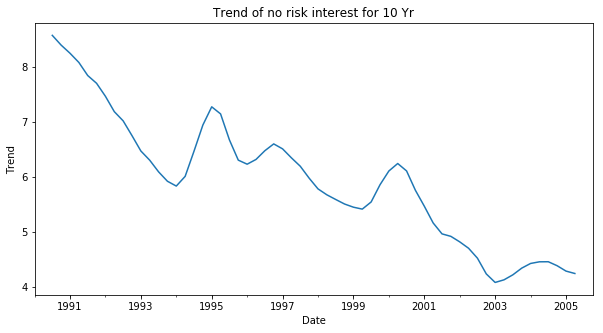

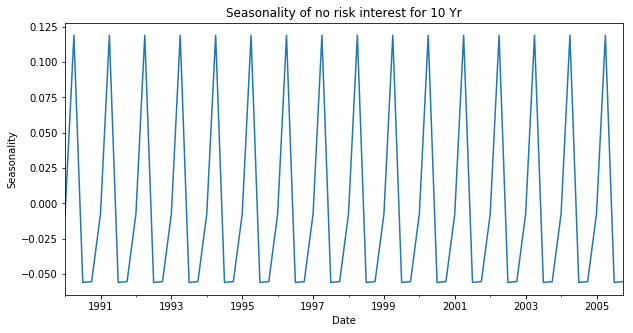

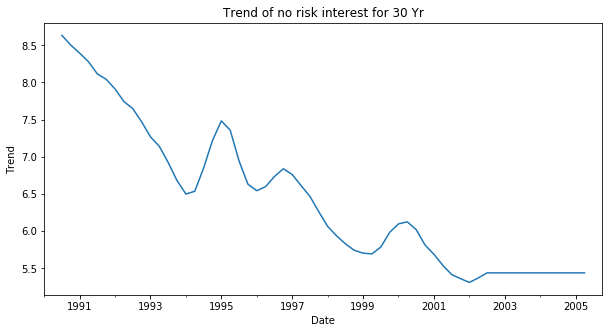

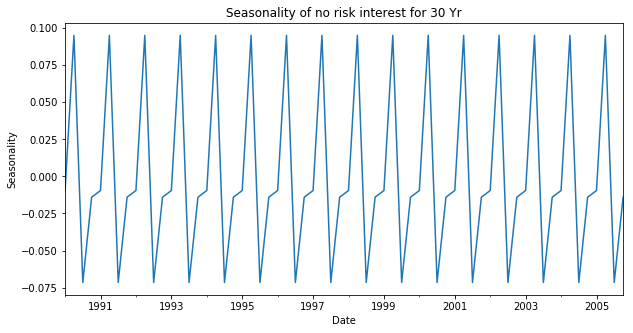

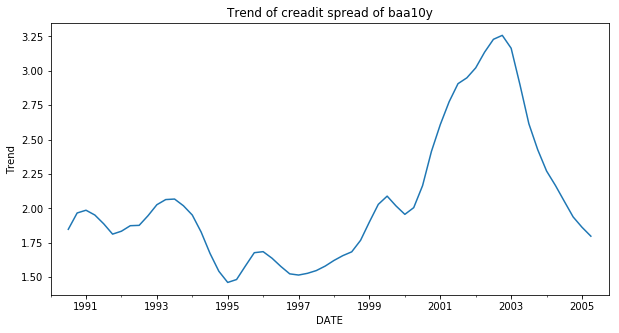

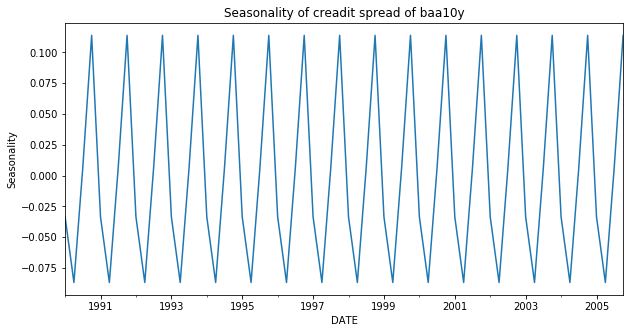

In [25]:
for period in PERIODS:
    data = prepare_data(daily_treasury_yield_curve_rate_df,
                        interest_periods=period,
                        data_source='yield',
                        start_date=START_DATE,
                        end_date=END_DATE,
                        fill=True, add_freq=True, freq='3m')
    result = seasonal_decompose(data, model='additive')

    plot_data(result.trend, xlabel='', ylabel='Trend', 
              title='Trend of no risk interest for {period}'.format(period=period))
    plot_data(result.seasonal, xlabel='', ylabel='Seasonality',
              title='Seasonality of no risk interest for {period}'.format(period=period))

data = prepare_data(baa10y_df,
                    interest_periods='BAA10Y',
                    data_source='baa10y',
                    start_date=START_DATE,
                    end_date=END_DATE,
                    fill=True, add_freq=True, freq='3m')

result = seasonal_decompose(data, model='additive')
plot_data(result.trend, xlabel='', ylabel='Trend', 
          title='Trend of creadit spread of baa10y')
plot_data(result.seasonal, xlabel='', ylabel='Seasonality',
          title='Seasonality of creadit spread of baa10y')


As can be seen, the trend is a smoothed average of the no risk interest.
The values of trend are between 1 to 8 while the values of seasonality are between -0.1 to 0.15, 
meaning the seasonality barely has any effect. It can be thought of that there is not seasonality for this period.

# 1.b.1 Checking stationarity

The properties (definition) of (weak) stationarity time series is:

1. Constant mean: for all t: E[y(t)] = M
2. Auto covariance depends only on the diffrenece in time: for all u,v,k cov(y(u),y(v)) = cov(y(u+a),y(v+a))
    
It can be inferred from the definition that in stationary time series there isn''t trend or seasonality. 
In all periods there is a trend, so we can assume that all serieses are not stationary.

For formality, I used Augmented Dickey-Fuller test, which is a statisitcal method which checks if time series is stationary:
1. The null hypothesis (H0) suggests that the series is non stationary. 
The alternative hypothesis (H1) suggests that the series is stationary.
2. We fail to reject H0 if p-value > 0.05. (non stationary). 
We reject H0 if p-value <= 0.05 (statonary)

In [27]:
from statsmodels.tsa.stattools import adfuller

In [28]:
for period in PERIODS:
    data = prepare_data(daily_treasury_yield_curve_rate_df,
                    interest_periods=period,
                    data_source='yield',
                    start_date=START_DATE,
                    end_date=END_DATE,
                    fill=True)
    
    result = adfuller(data.values)
    p_value = result[1]
    
    print('p-value for period {period} is: {p_value}'.format(period=period, p_value=p_value))
    if p_value <= 0.05:
        print('Time series of no risk interest for {period} is stationary \n'.
              format(period=period))
    else:
        print('Time series of no risk interest for {period} is not stationary \n'.
              format(period=period))

data = prepare_data(baa10y_df,
                    interest_periods='BAA10Y',
                    data_source='baa10y',
                    start_date=START_DATE,
                    end_date=END_DATE,
                    fill=True)

result = adfuller(data.values)
p_value = result[1]

print('p-value for creadit spread of baa10y is: {p_value}'.format(period=period, p_value=p_value))
if p_value <= 0.05:
    print('Time series of creadit spread of baa10y is stationary \n')
else:
    print('Time series of creadit spread of baa10y is not stationary \n')

p-value for period 3 Mo is: 0.21647204704170303
Time series of no risk interest for 3 Mo is not stationary 

p-value for period 1 Yr is: 0.22672733645965726
Time series of no risk interest for 1 Yr is not stationary 

p-value for period 5 Yr is: 0.43956450999929547
Time series of no risk interest for 5 Yr is not stationary 

p-value for period 10 Yr is: 0.5055555888615472
Time series of no risk interest for 10 Yr is not stationary 

p-value for period 30 Yr is: 0.5093712370375637
Time series of no risk interest for 30 Yr is not stationary 

p-value for creadit spread of baa10y is: 0.24114541439083315
Time series of creadit spread of baa10y is not stationary 



# Co-Integration test

In [42]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
df_yield = prepare_data(daily_treasury_yield_curve_rate_df,
                    interest_periods=PERIODS,
                    data_source='yield',
                    start_date=START_DATE,
                    end_date=END_DATE,
                    fill=True)

df_bay = prepare_data(baa10y_df,
            interest_periods='BAA10Y',
            data_source='baa10y',
            start_date=START_DATE,
            end_date=END_DATE,
            fill=True)

df = pd.concat([df_yield,df_bay],axis=1).dropna()

for lag in range(1,6):
    print("lag = {lag}".format(lag=lag))
    print('#'*50)
    print(select_coint_rank(df, 1, lag, method='trace'))

lag = 1
##################################################
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   6          213.7          107.3
  1   6          130.0          79.34
  2   6          76.45          55.25
  3   6          32.90          35.01
-------------------------------------
lag = 2
##################################################
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   6          205.7          107.3
  1   6          119.5          79.34
  2   6          71.59          55.25
  3   6          32.31          35.01
-------------------------------------
lag = 3
##################################################
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------

In [ ]:
# from statsmodels.tsa.vector_ar.vecm import coint_johansen
# print(coint_johansen(df,0,1).cvt)
# print(coint_johansen(df,0,1).lr1)
# print(coint_johansen(df,0,1).evec)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

daily_treasury_yield_curve_rate_df = pd.read_csv('daily_treasury_yield_curve_rate.csv',
                                                 parse_dates=['Date'], index_col='Date')
start_period = 11
end_period = 12
for idx,period in enumerate(COLUMNS[start_period:end_period]):
    data = daily_treasury_yield_curve_rate_df[COLUMNS[idx+start_period]]
    data = data.sort_index(axis=0)
    data.plot(x='date',y='daily_treasury_yield_curve_rate',figsize=(20,10))
    rolling_mean = data.rolling(window=30).mean()
    rolling_mean.plot(label='rolling mean')
#     rolling_std = data.rolling(window=30).std()
#     rolling_std.plot(label='rolling std')
#     plt.legend(loc='best')
    mean_list = list(map(lambda idx: data[data.index < idx].mean(),data.index))        
    plt.plot([i for i in range(len(mean_list))], mean_list)

    data = data.diff(periods=30)
    mean_list = list(map(lambda idx: data[data.index < idx].mean(),data.index))    
    print(min(mean_list[1000:]))
    print(max(mean_list[1000:]))
    plt.plot([i for i in range(len(mean_list))], mean_list)

In [ ]:
passengers = pd.read_csv('airline-passengers.csv',parse_dates=['Month'], index_col='Month')
passengers.plot()

In [ ]:
rolling_std = passengers.rolling(window=30).std()
rolling_std.plot(label='rolling std')